<a href="https://colab.research.google.com/github/Chubbyman2/Emotion_Detector/blob/main/Emotion_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import keras
import numpy as np
from keras import optimizers, models, layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')

!unzip "/content/drive/My Drive/facial_expressions_train.zip"
!unzip "/content/drive/My Drive/facial_expressions_validation.zip"

In [4]:
train_dir = "train"
val_dir = "validation"

(48, 48)


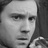

In [7]:
# Image sample from dataset
# Note that they are all grayscale images with size 48x48
from PIL import Image

img = Image.open("train/Angry/0.jpg")
print(img.size)
img

**Data Pre-Processing**

In [8]:
# Create a dictionary of the classes and a reverse dictionary
classes = dict()
reverse_classes = dict()
count = 0
for folder in os.listdir("train"):
    classes[folder] = count
    reverse_classes[count] = img
    count = count + 1

classes

{'Angry': 2, 'Happy': 4, 'Neutral': 1, 'Sad': 0, 'Surprise': 3}

In [9]:
BATCH_SIZE = 64

# Since the data is separated into training and validation sets this time
# we can use the ImageDataGenerator directly

# Data augmentation for train only
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   shear_range=0.3,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
# Resize only
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
# Create the generators for model.fit()
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    color_mode='grayscale',
                                                    target_size=(48, 48),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    shuffle=True)

val_generator = val_datagen.flow_from_directory(val_dir,
                                                color_mode='grayscale',
                                                target_size=(48, 48),
                                                batch_size=BATCH_SIZE,
                                                class_mode='categorical',
                                                shuffle=True)

# Note the text shown
num_train = 24256
num_val = 3006

Found 24256 images belonging to 5 classes.
Found 3006 images belonging to 5 classes.


**Create Model**

In [11]:
# Apply batchnormalization before activation function
# He normal initialization works best on layers w/ ReLU activation
model = models.Sequential([
    # Block 1
    # Leave strides as default since images are small
    Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal", input_shape=(48, 48, 1)),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(32, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 2
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 3
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 4
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(256, (3, 3), padding="same", kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.25),

    # Block 5
    Flatten(),
    Dense(64, kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    # Block 6
    Dense(128, kernel_initializer="he_normal"),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),

    # Output layer
    # Xavier (a.k.a. GlorotNormal) works better on layers w/ softmax activation
    Dense(5, kernel_initializer="glorot_normal", activation="softmax")
])

In [12]:
model.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [13]:
Checkpoint = ModelCheckpoint("emotion_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)
EarlyStopping = EarlyStopping(monitor="val_loss",
                              min_delta=0,
                              patience=3,
                              verbose=1,
                              restore_best_weights=True)
Reduce_LR = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.2, # Decrease by 20% each time
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

In [14]:
history = model.fit(train_generator, 
                    steps_per_epoch=num_train//BATCH_SIZE,
                    epochs=25,
                    callbacks=[Checkpoint, EarlyStopping, Reduce_LR],
                    validation_data=val_generator,
                    validation_steps=num_val//BATCH_SIZE)

Epoch 1/25
379/379 [==============================] - ETA: 0s - loss: 1.7648 - accuracy: 0.2523
Epoch 00001: val_loss improved from inf to 1.55815, saving model to emotion_classifier.h5
379/379 [==============================] - 22s 58ms/step - loss: 1.7648 - accuracy: 0.2523 - val_loss: 1.5581 - val_accuracy: 0.2945
Epoch 2/25
379/379 [==============================] - ETA: 0s - loss: 1.6065 - accuracy: 0.2782
Epoch 00002: val_loss did not improve from 1.55815
379/379 [==============================] - 21s 56ms/step - loss: 1.6065 - accuracy: 0.2782 - val_loss: 1.5845 - val_accuracy: 0.2935
Epoch 3/25
379/379 [==============================] - ETA: 0s - loss: 1.5629 - accuracy: 0.2939
Epoch 00003: val_loss did not improve from 1.55815
379/379 [==============================] - 21s 55ms/step - loss: 1.5629 - accuracy: 0.2939 - val_loss: 1.5846 - val_accuracy: 0.2948
Epoch 4/25
379/379 [==============================] - ETA: 0s - loss: 1.5328 - accuracy: 0.3129
Epoch 00004: val_loss imp

In [15]:
model.save("emotion_classifier.h5")

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

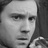

In [17]:
# The model predicted the sample image accurately
image = Image.open("train/Angry/0.jpg")
image = image.resize((48, 48))
arr = np.array(image)
x_data = [arr]
x_data = np.array(x_data, dtype = "float32")
x_data = x_data.reshape((len(x_data), 48, 48, 1))
x_data /= 255

pred_array = model.predict(x_data)
result = reverse_classes[np.argmax(pred_array)]
result

**Plot Training and Validation Graphs**

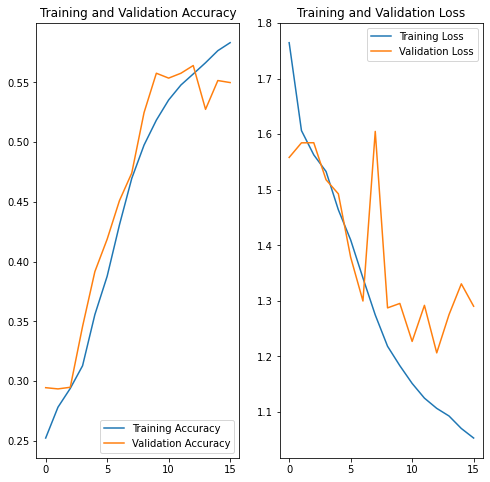

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(16)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()